# Experiment

In [216]:
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from skimage import color, io, transform

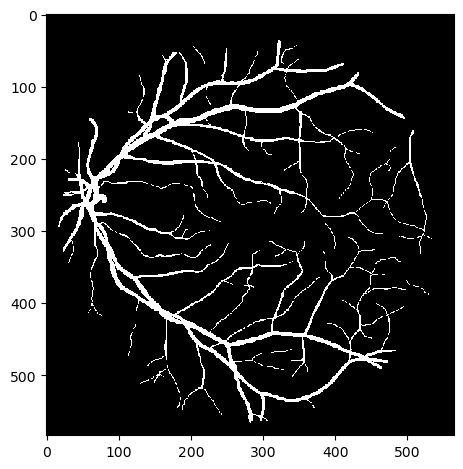

In [217]:
img = io.imread('data/DRIVE/training/1st_manual/21_manual1.gif')[0,:,:]

io.imshow(img)
io.show()

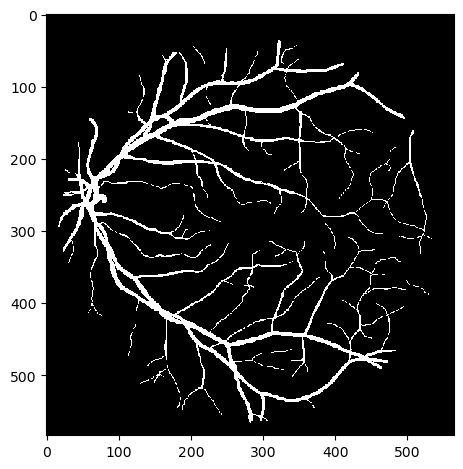

In [218]:
# img = img - np.mean(img)
# img = color.rgb2gray(img)


# img_smooth = scipy.ndimage.filters.gaussian_filter(img, sigma=1)
io.imshow(img, cmap='gray')
io.show()

In [219]:
def grad(x):
    return np.array(np.gradient(x))

def norm(x, axis=0):
    return np.sqrt(np.sum(np.square(x), axis=axis))

def stopping_fun(x):
    return 1. / (1. + norm(grad(x))**2)

F_v = stopping_fun(img)
print(img.shape)

(584, 565)


In [220]:
class TimeScheme(object):
	def __init__(self, dt):
		self.dt = dt

	def EulerForward(self, u, rhs, i, j):
		return u[i, j] - self.dt * rhs(u, i, j)

	def RungeKutta(self, u, rhs, i, j):
		k1 = rhs(u, i, j)
		k2 = rhs(u - 0.5*self.dt*k1, i, j)
		k3 = rhs(u - 0.5*self.dt*k2, i, j)
		k4 = rhs(u - self.dt*k3, i, j)
		return u[i, j] + self.dt*(k1 + 2*k2 + 2*k3 + k4)/6	

class SpatialScheme:
	@staticmethod
	def Upwind(u, i, j, ii, jj):
		return u[i, j] - u[ii, jj]


In [221]:
from matplotlib import colors


class levelset:
	def __init__(self,phi, dt, nt, timesch, spatialsch):
		self.phi=phi
		self.nx=phi.shape[0]
		self.ny=phi.shape[1]
		self.nt = nt
		self.dx=1.0/(self.nx-1)
		self.dy=1.0/(self.ny-1)
		self.dt=dt
		self.initialize()
		self.timesch=timesch
		self.spatialsch=spatialsch

	def initialize(self):
		for i in range(self.nx):
			for j in range(self.ny):
				# self.phi[i,j]=np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2))-(self.nx/4)
				self.phi[i, j] = max(self.nx/4 - i, i - self.nx/1.5, self.ny/4 - j, j - self.ny/1.5)

	def boundary_condition(self, phi):
		phi[0, :] = phi[1, :]
		phi[-1, :] = phi[-2, :]
		phi[:, 0] = phi[:, 1]
		phi[:, -1] = phi[:, -2]
		return phi


	def reinitialize(self, step):
		phi0 = self.phi.copy()
		for _ in range(step):
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					grad_phi_x = (phi0[i+1,j]-phi0[i-1,j])/(2 * self.dx)
					grad_phi_y = (phi0[i,j+1]-phi0[i,j-1])/(2 * self.dy)
					grad_phi = np.sqrt(grad_phi_x**2+grad_phi_y**2)
					s = phi0[i,j] / np.sqrt(phi0[i,j]**2 + self.dx**2)
					dphi = s * (grad_phi - 1)
					phi0[i, j] = phi0[i, j] - self.dt * dphi
			phi0 = self.boundary_condition(phi0)
		return phi0


	def F(self, i, j):
		return F_v[i,j]

	def rhs(self, phi, i, j):
		delt_xn = self.spatialsch(phi, i, j, i-1, j)
		delt_yn = self.spatialsch(phi, i, j, i, j-1)
		delt_xp = self.spatialsch(phi, i+1, j, i, j)
		delt_yp = self.spatialsch(phi, i, j+1, i, j)
		deltp = max(delt_xn/self.dx, 0)**2 + max(delt_yn/self.dy, 0)**2 + min(delt_xp/self.dx, 0)**2 + min(delt_yp/self.dy, 0)**2
		deltn = max(delt_xp/self.dx, 0)**2 + max(delt_yp/self.dy, 0)**2 + min(delt_xn/self.dx, 0)**2 + min(delt_yn/self.dy, 0)**2
		F = self.F(i,j)
		return max(F, 0) * np.sqrt(deltp) + min(F, 0) * np.sqrt(deltn)

	def evolve(self):
		for t in range(self.nt):
			if t % 10 == 0:
				# print(self.phi[self.phi<=0].shape)
				fig = self.phi.copy()
				fig[self.phi <= 0] = 255
				fig[self.phi > 0] = 0
				print(np.sum(np.logical_and(fig, img)/ np.sum(np.logical_or(img, fig))))
				# plt.contourf(fig, alpha=0.5)
				plt.contour(fig, levels=[0], colors = 'r')
				io.imshow(img)
				plt.title(f"time={t*self.dt}")
				plt.show()
			self.phi = self.boundary_condition(self.phi)
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					self.phi[i, j] = self.timesch(self.phi, self.rhs, i, j)

			# if t % 5 == 0:
			# 	self.phi = self.reinitialize(10)

	

0.06478463556207716


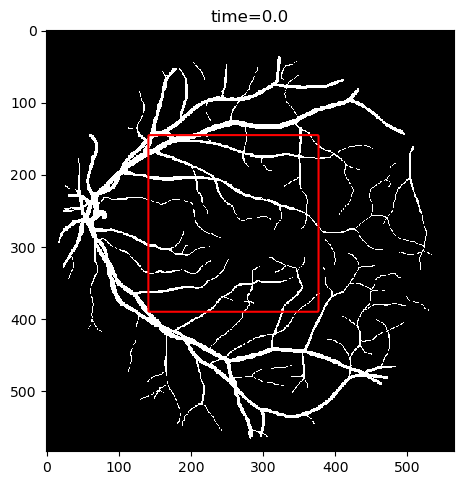

0.06143203520908265


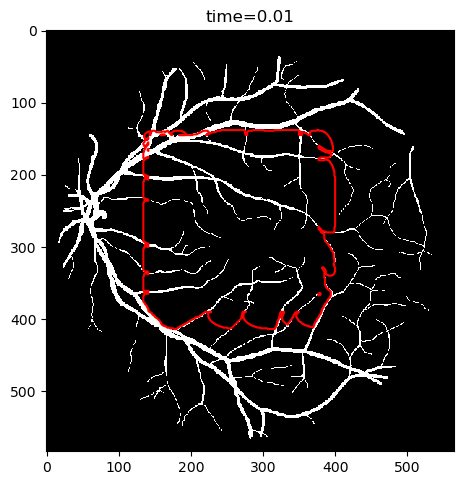

0.06000513412912335


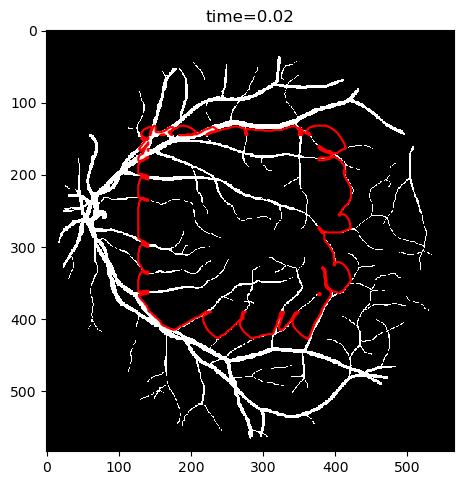

0.06001329311314485


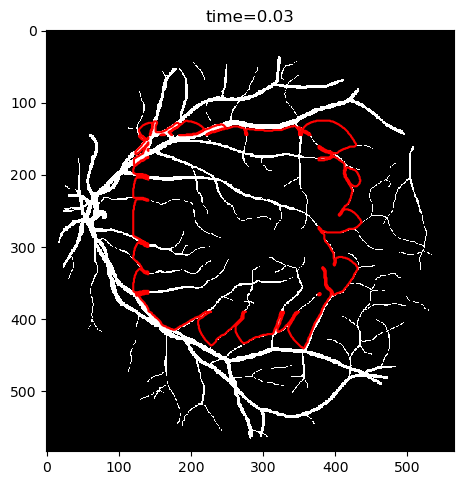

0.06126441616371087


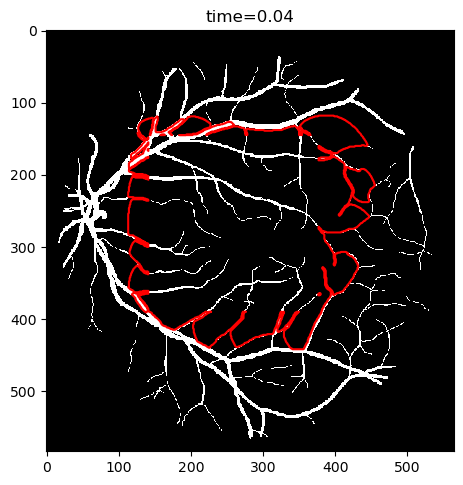

0.06397585816672954


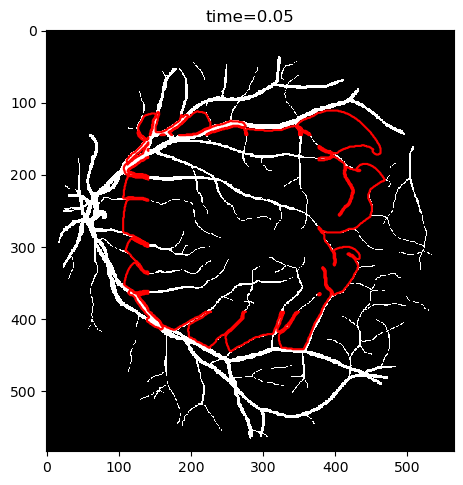

0.0660773380479623


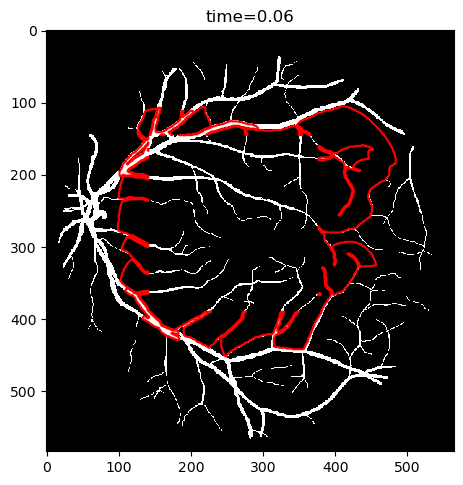

0.06791618405812364


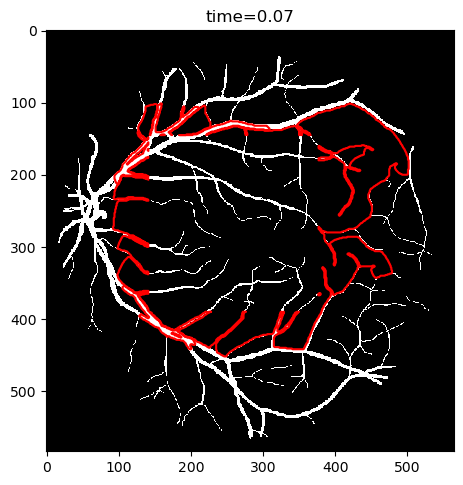

0.07030982246898346


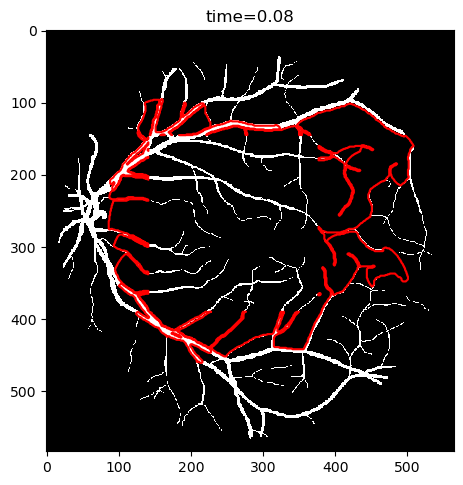

0.07180238120990755


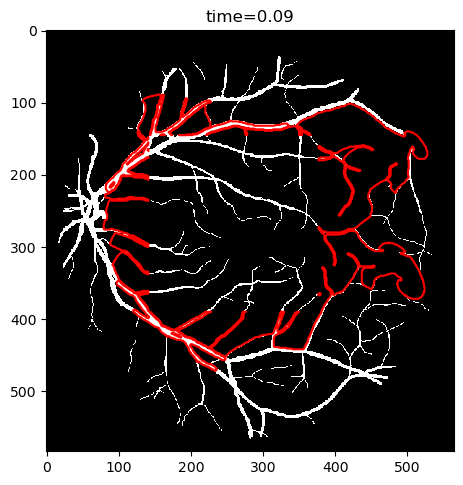

0.07266203722201356


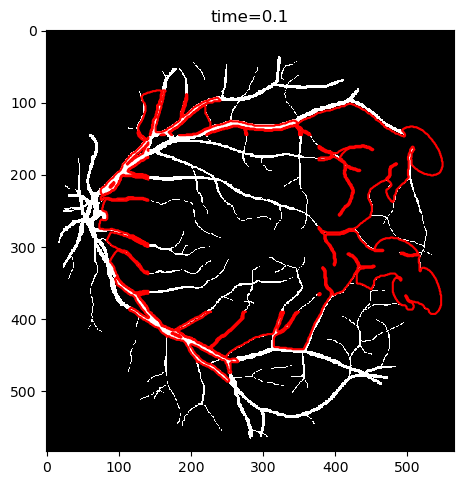

0.07258724720293504


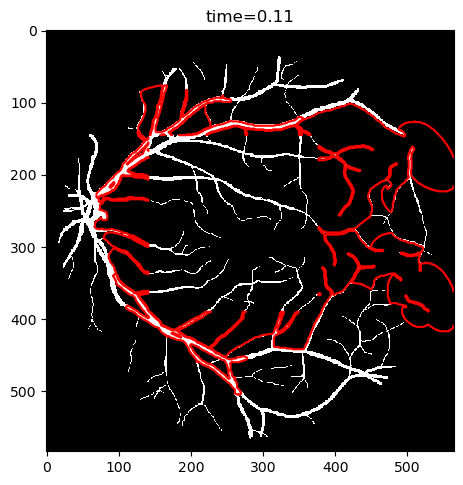

0.0730839216828008


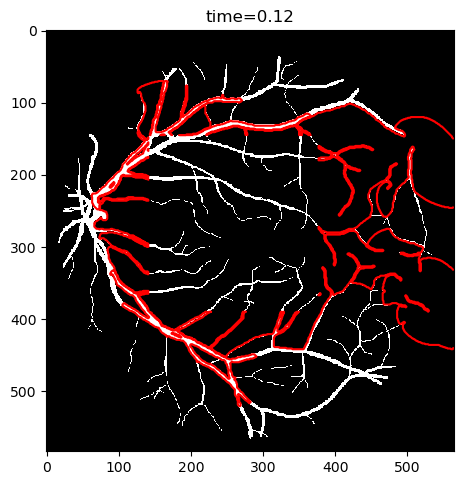

0.07542758446372903


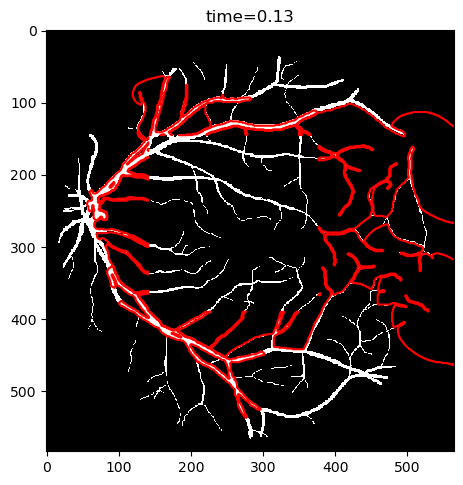

0.0770071704057798


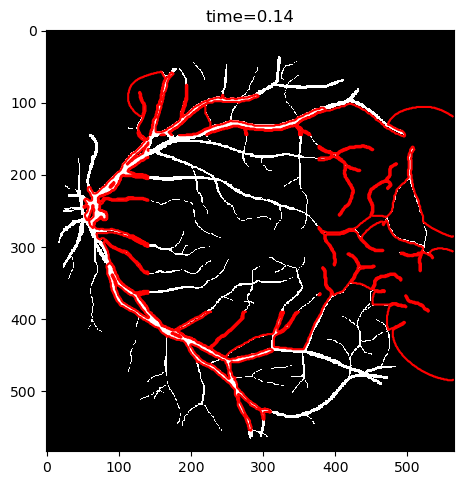

0.0790509411609846


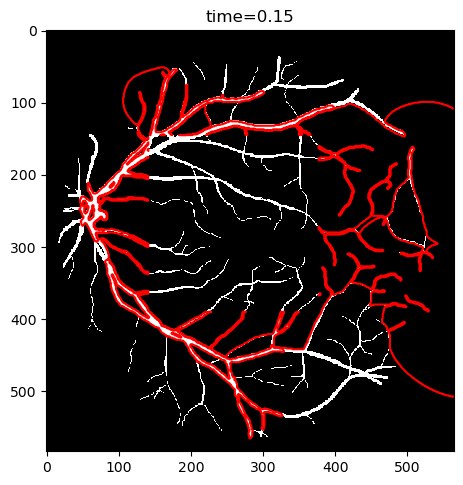

0.08038659496091695


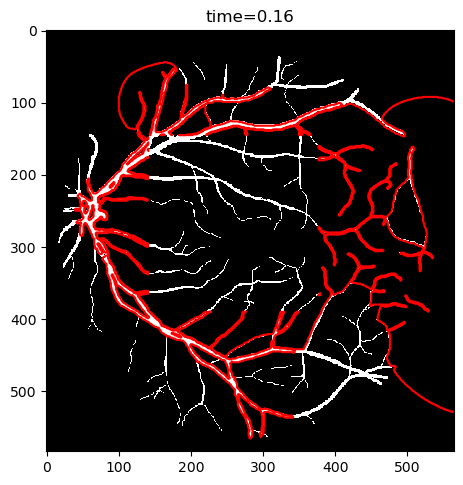

0.08035228062268789


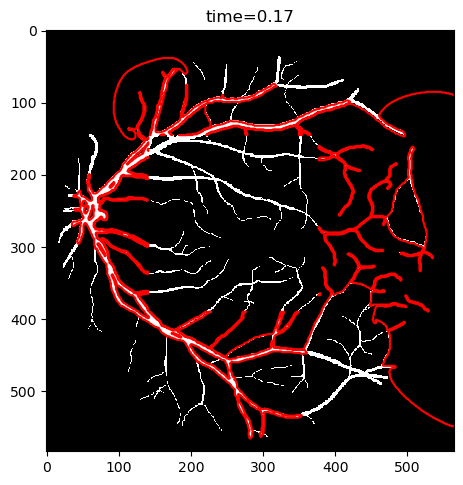

0.07972226261451212


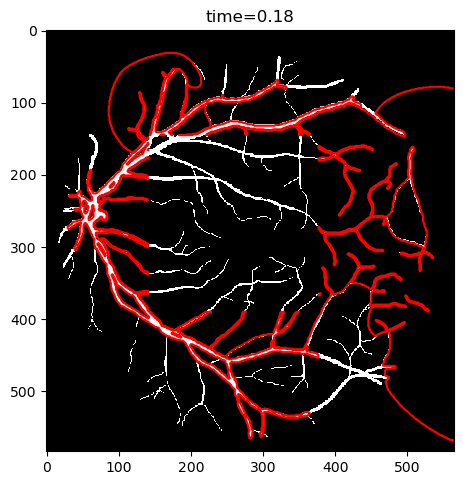

0.07880835812504393


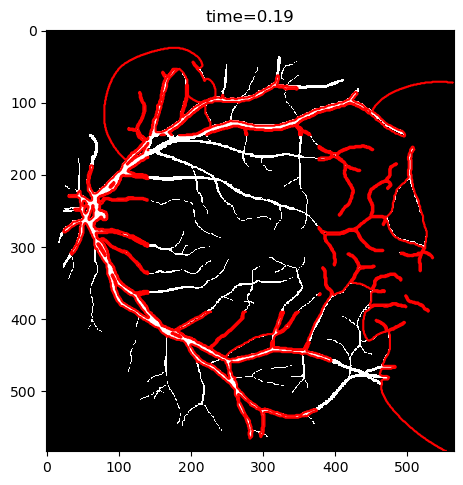

0.07779095029297815


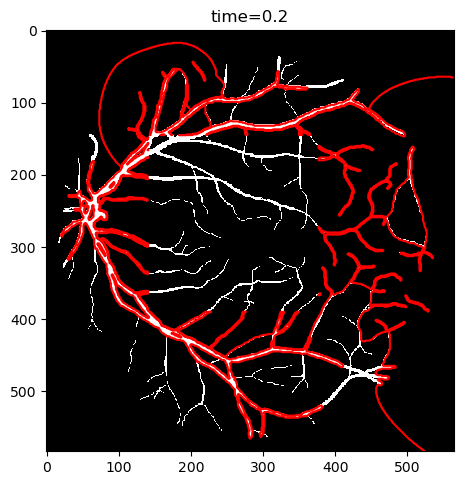

0.07676549031734374


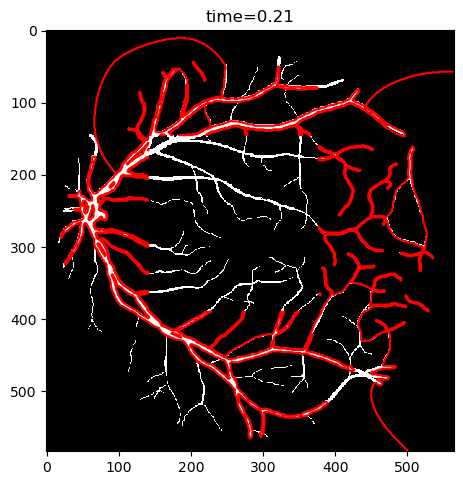

0.07611463593594887


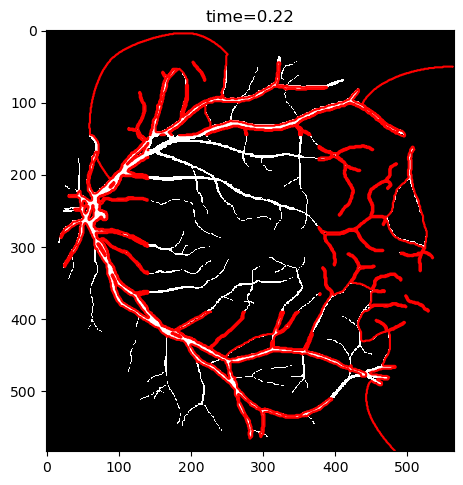

0.07555679668688188


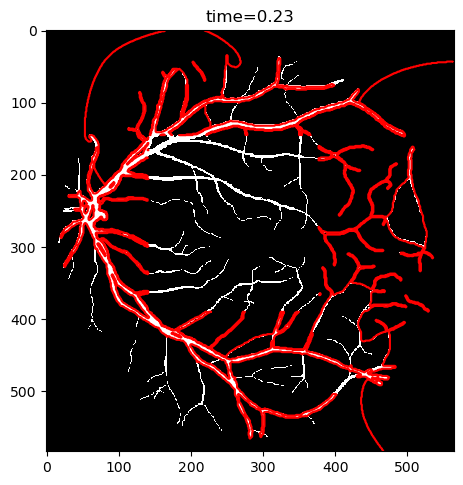

0.07427759307146084


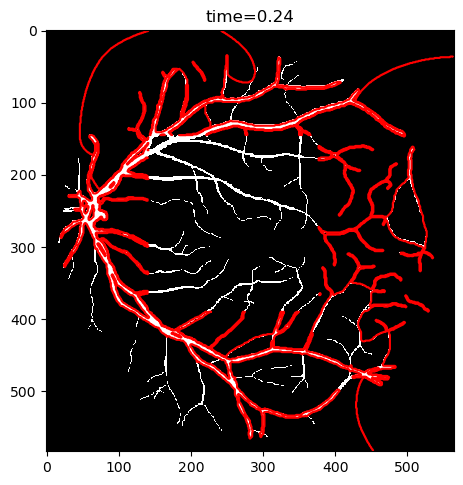

0.07295922203563998


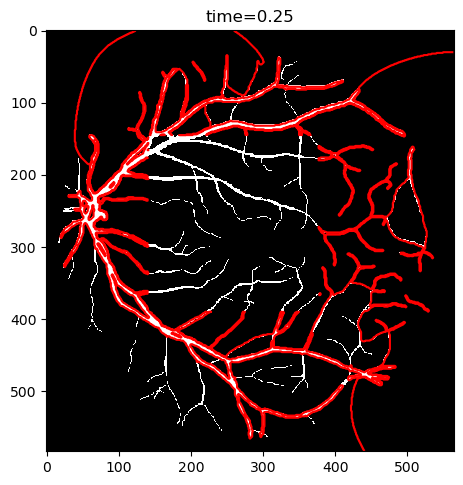

0.07163260606476331


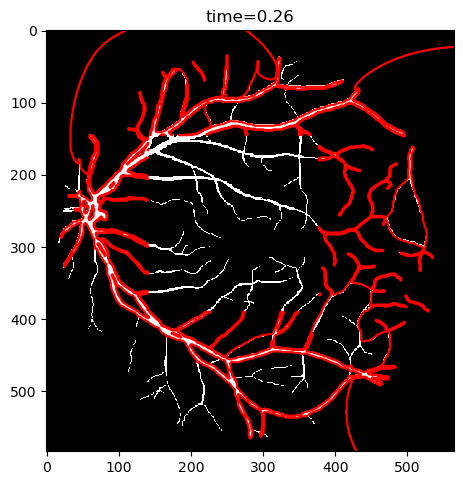

0.07021518641008781


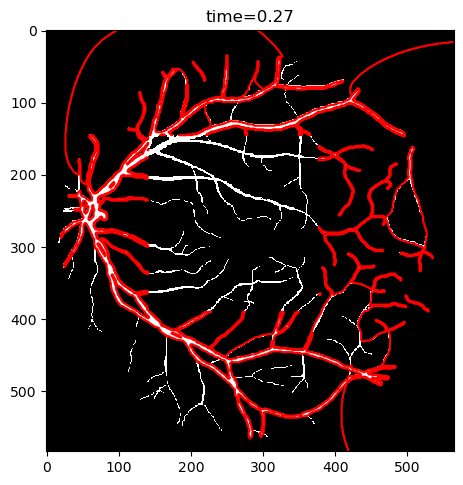

0.06876386747395735


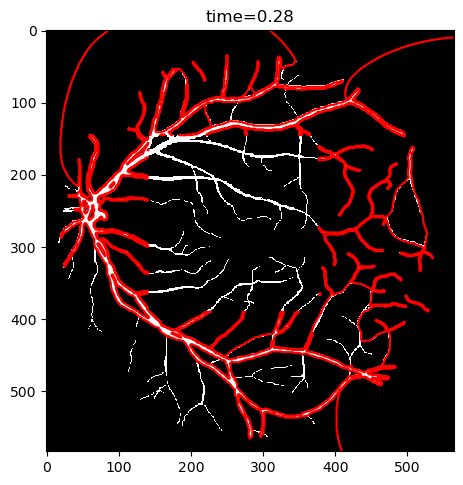

0.06739274657231312


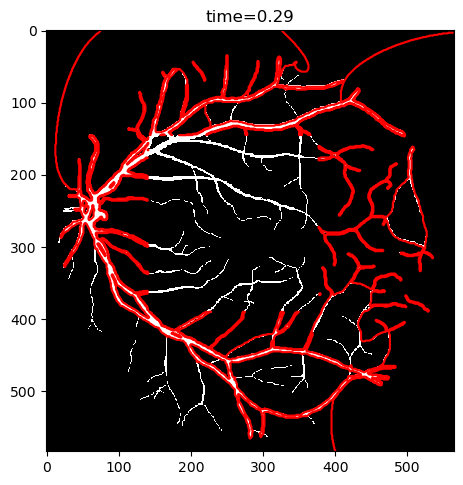

0.06588922070726864


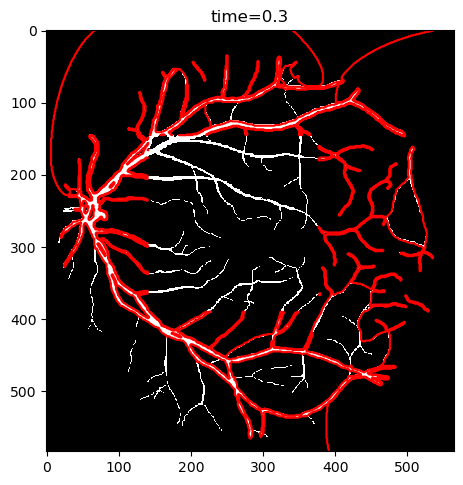

0.0644652355748679


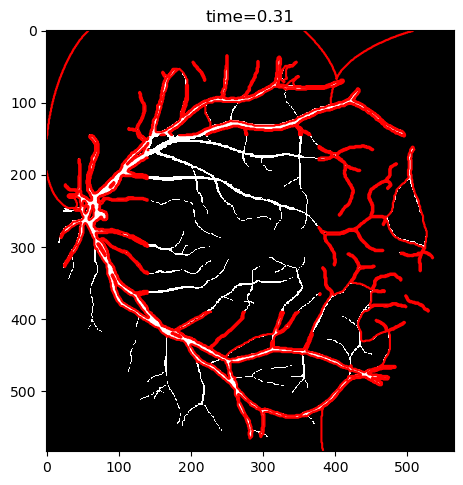

0.0634700244282361


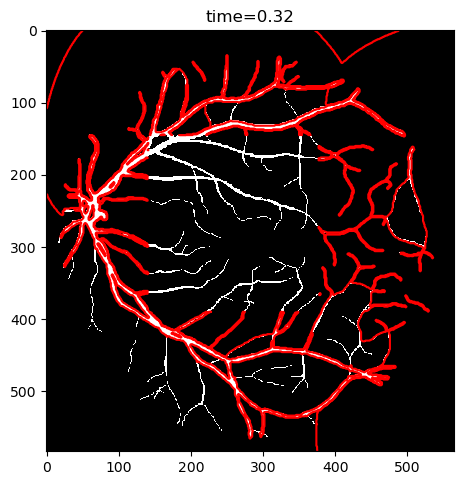

0.06269044343588885


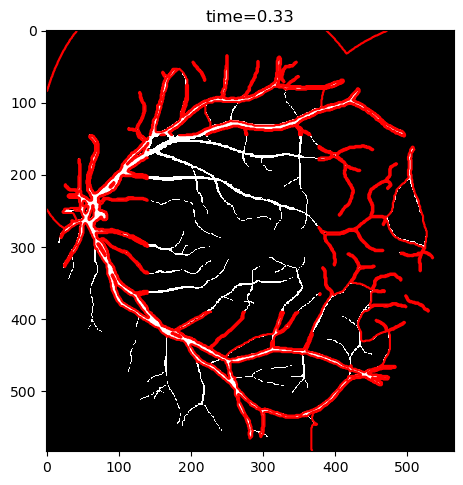

0.062116759805004


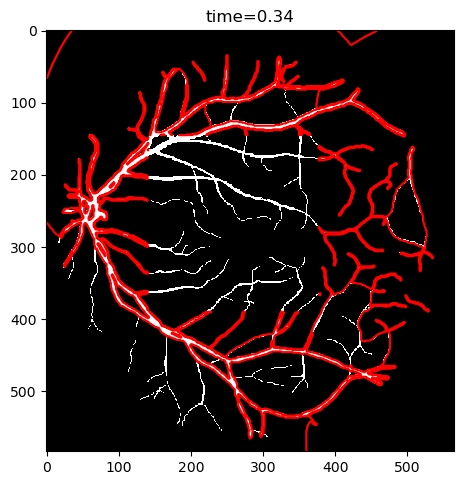

0.06170199304017716


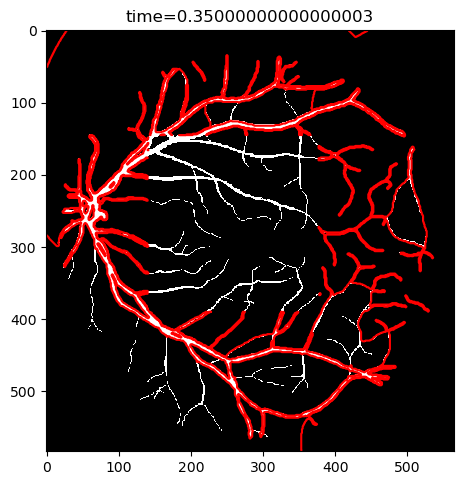

0.06129820283005032


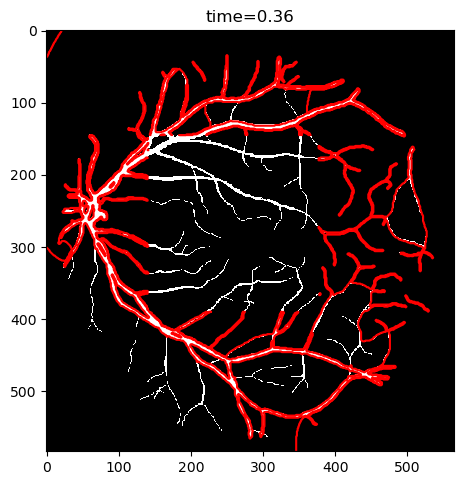

0.06096331116334116


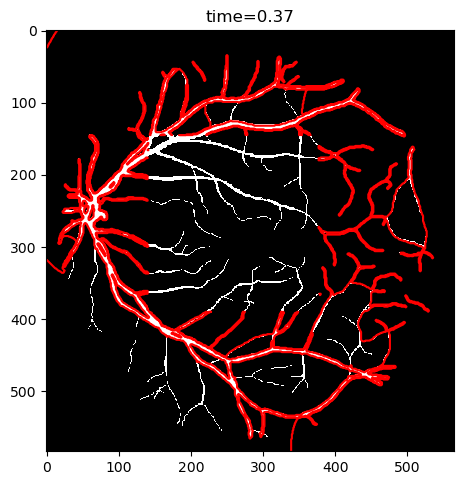

0.06061422190548011


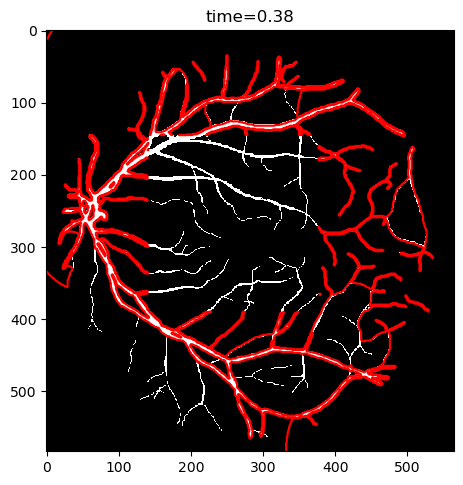

0.060249498572940645


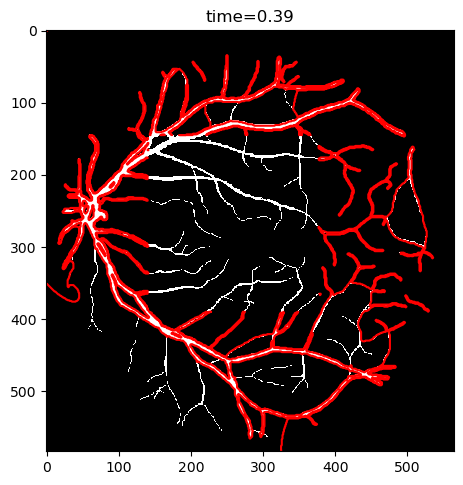

0.05973549791150327


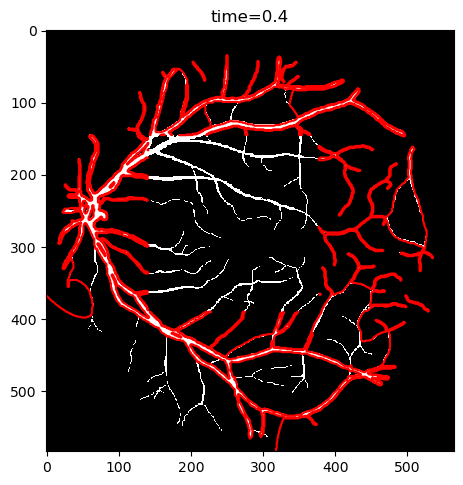

0.0592919816004377


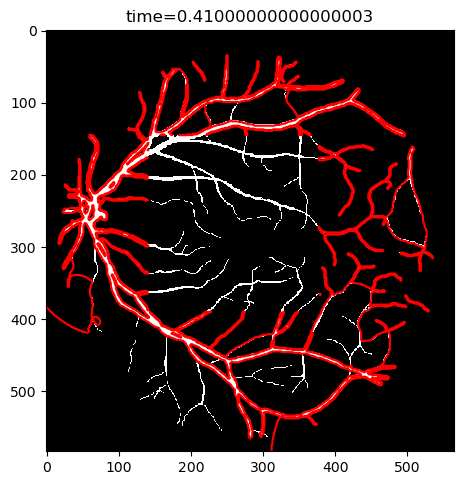

0.05866552272973288


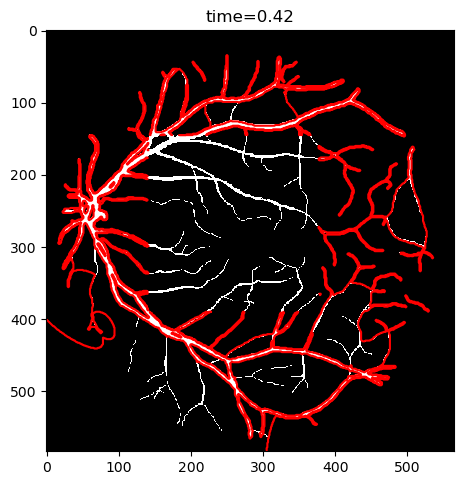

0.05777674242304596


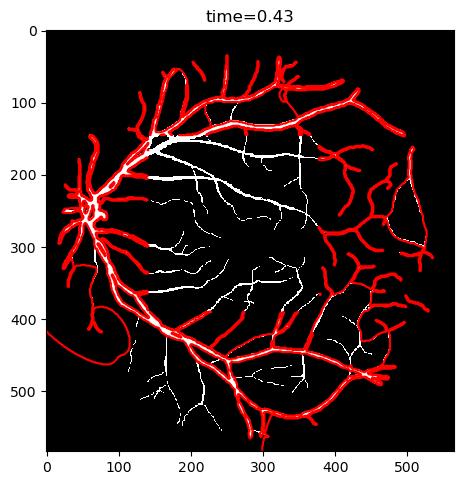

0.05685504391843331


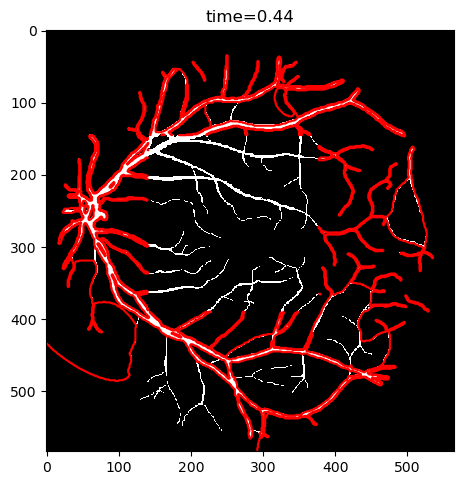

0.05598610675459601


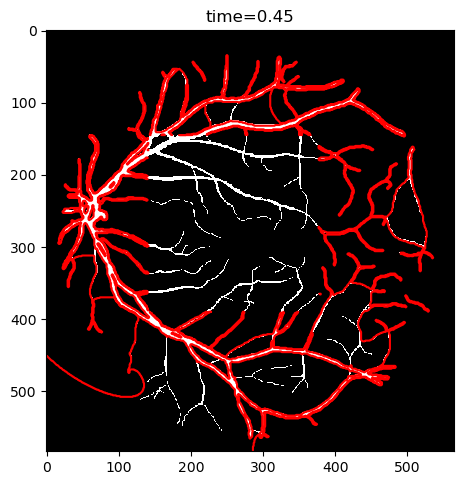

0.05512410078716433


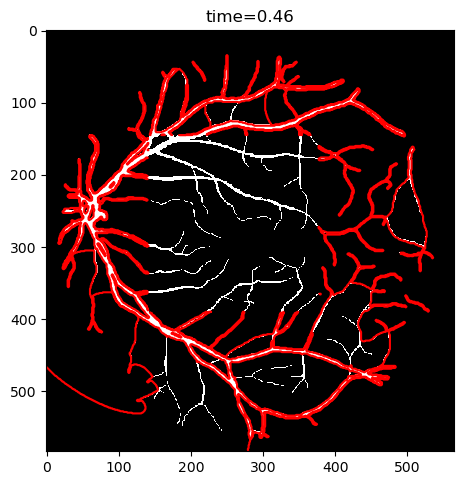

0.05419565531311439


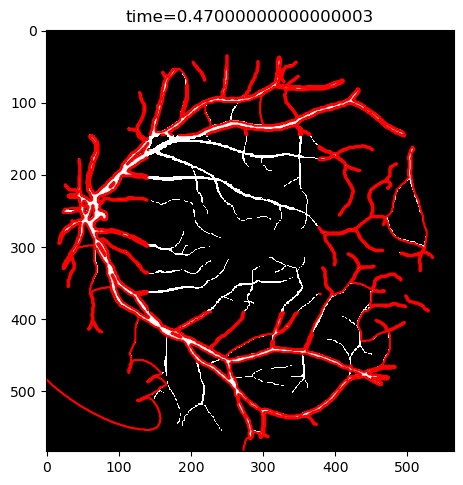

0.053161164752404774


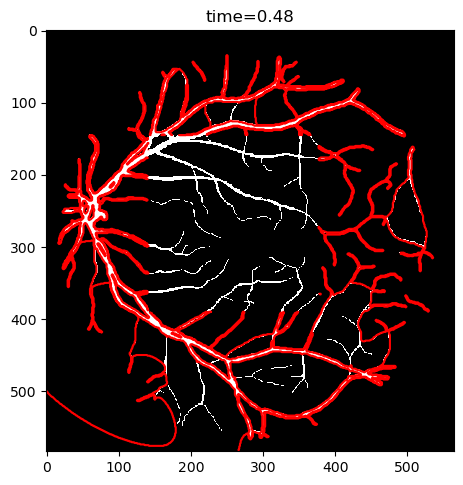

0.05223180360271006


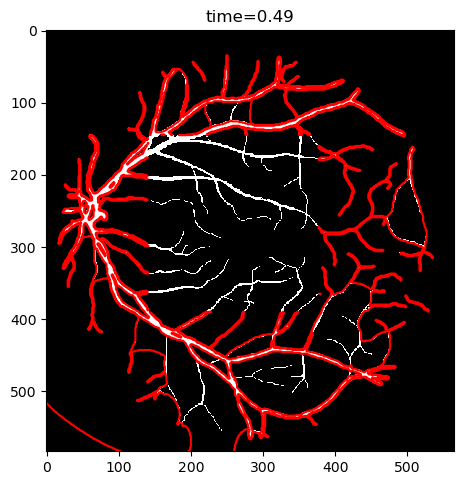

0.05164282816881537


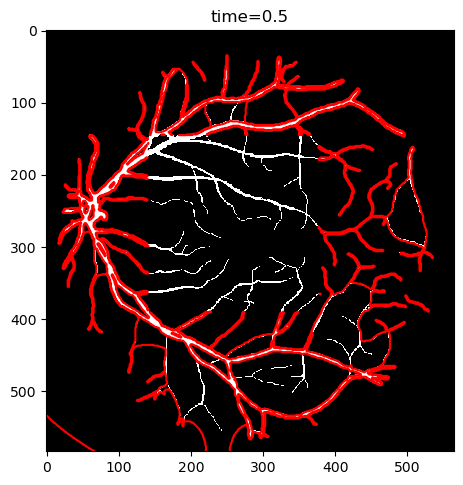

0.051161717993786916


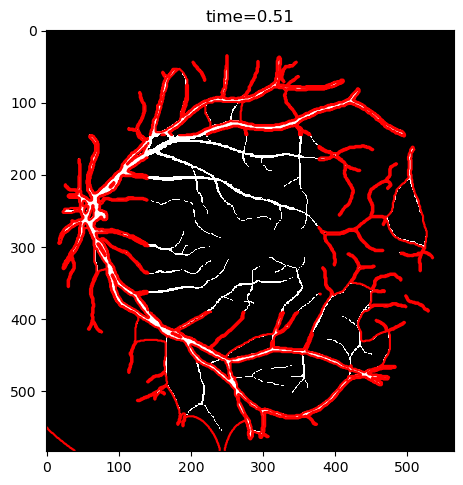

0.05079183361953824


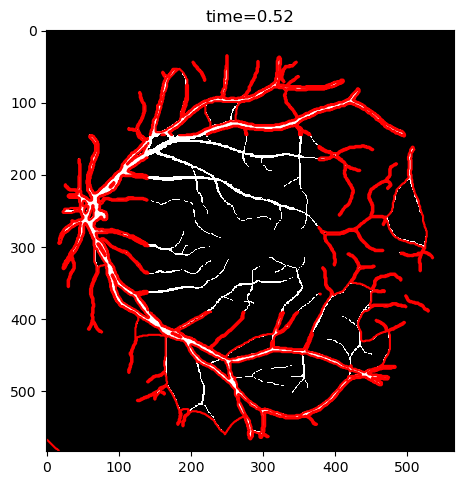

0.050618163211682866


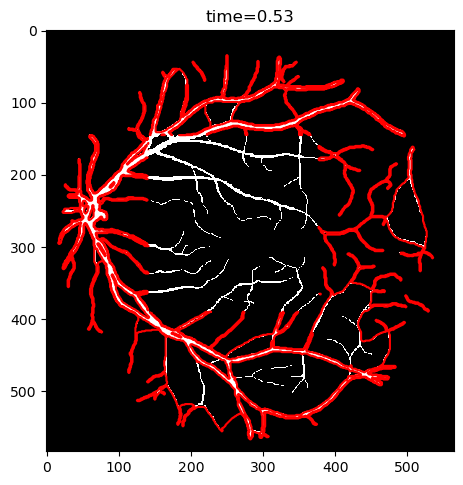

0.05053648438847679


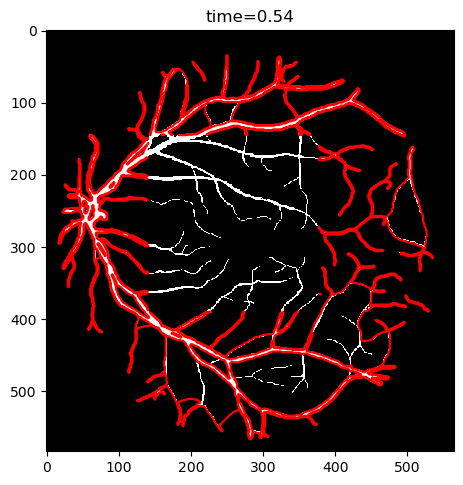

0.05044091467844735


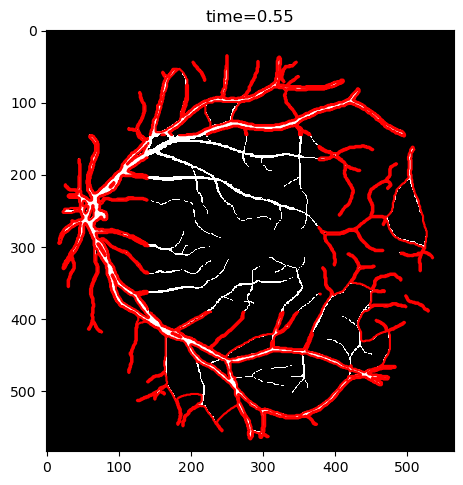

0.050358005891714824


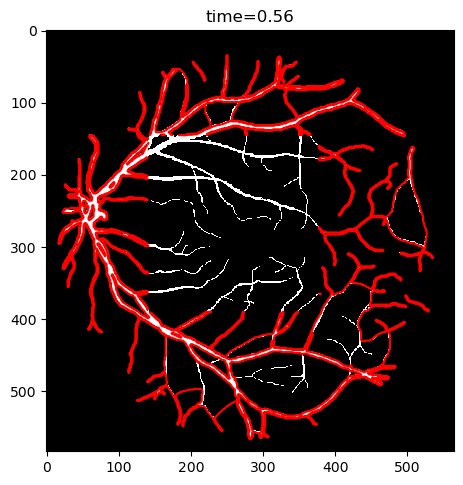

0.050274191666495105


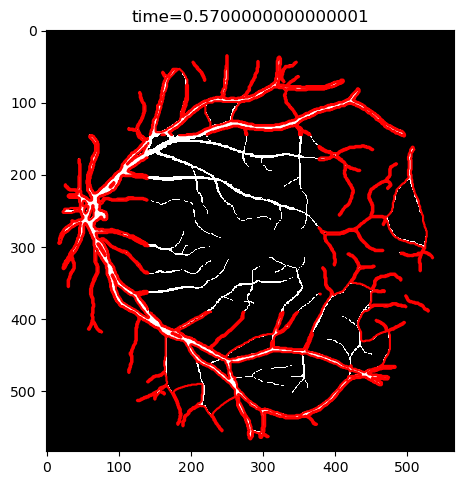

0.0501884206920178


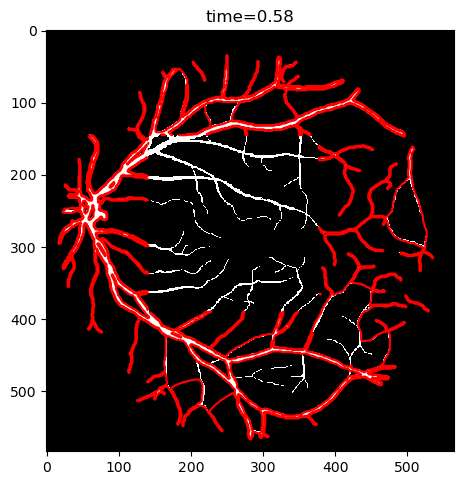

0.05009968640674107


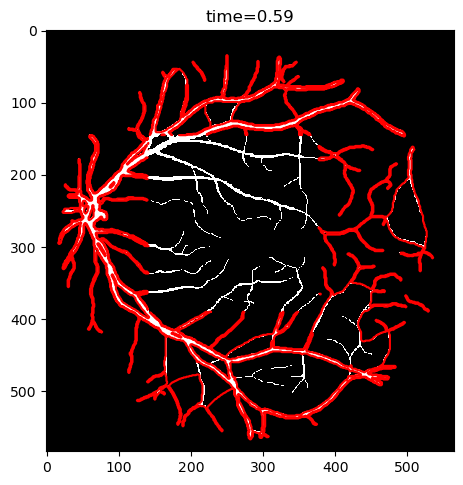

0.050009558140805065


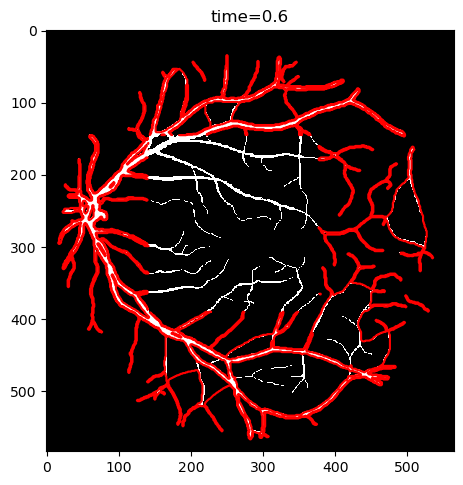

0.04992519740048186


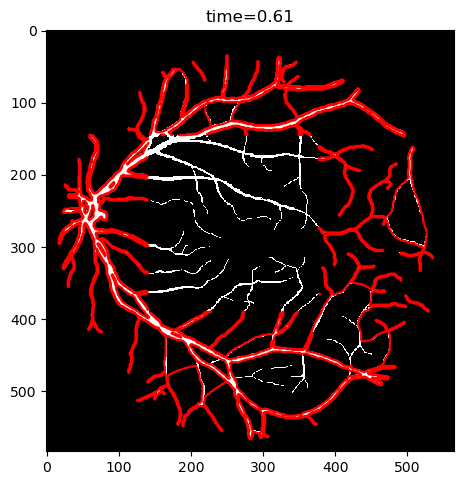

0.049848922038327526


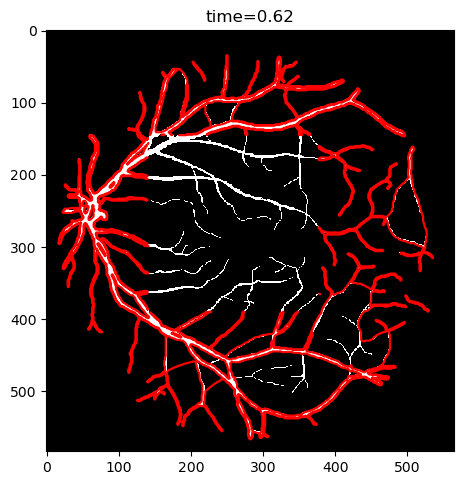

0.049782181716856624


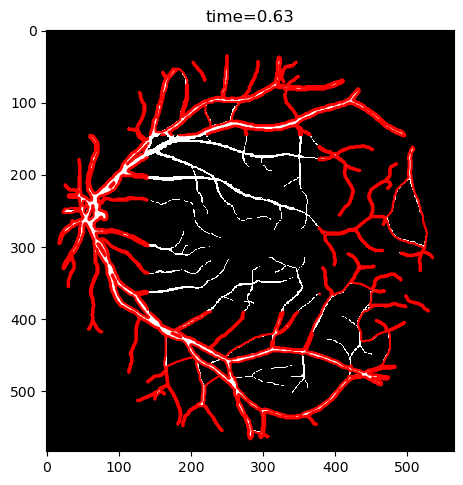

0.04972846378385716


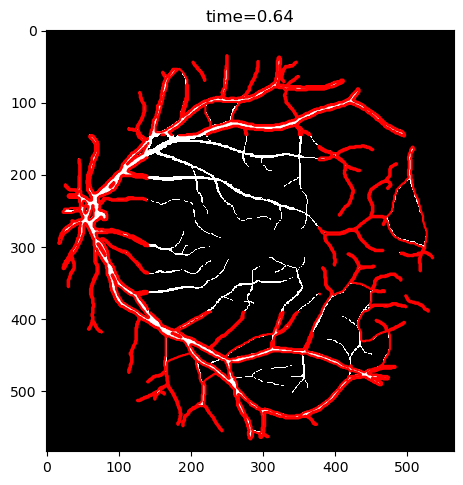

0.049683649457830104


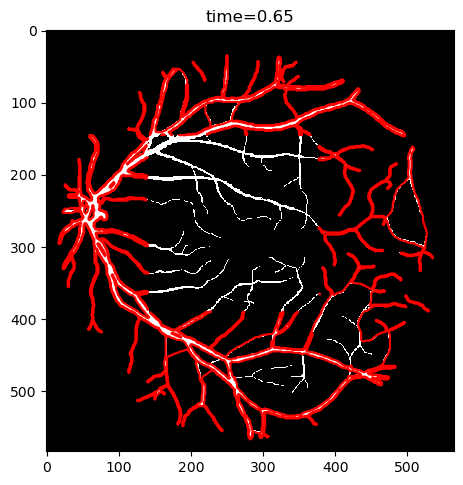

0.04964445302680748


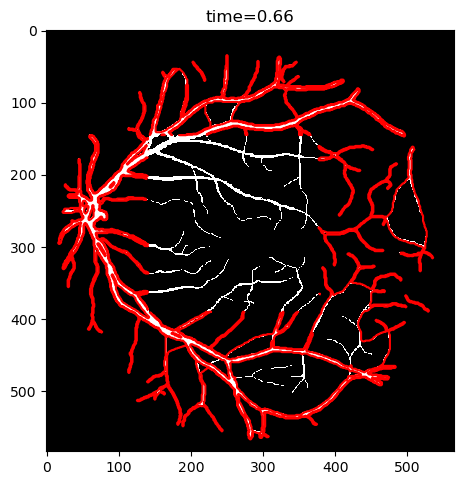

0.04961727396142609


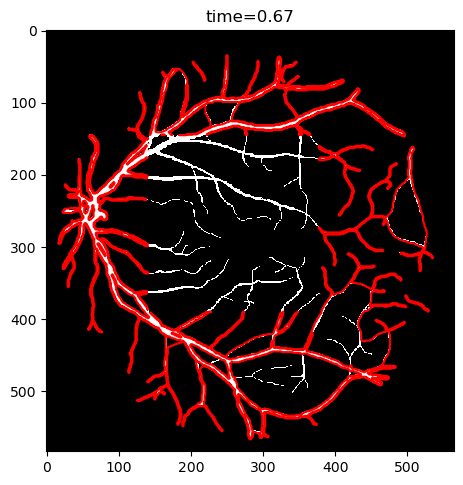

0.04959779625512272


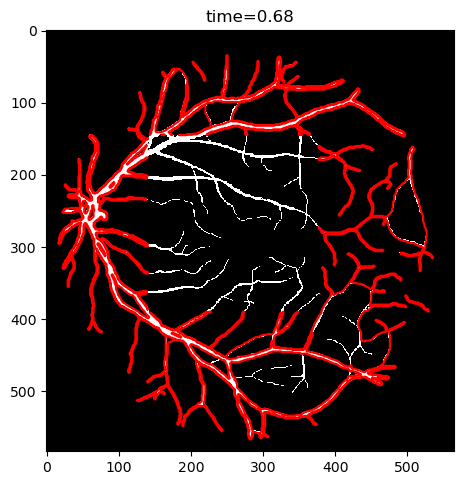

0.04959141895206998


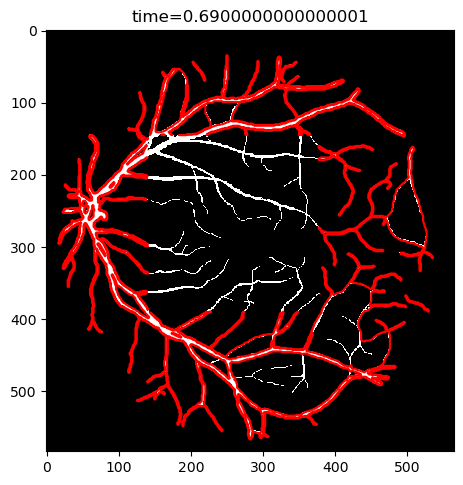

0.04959734722880152


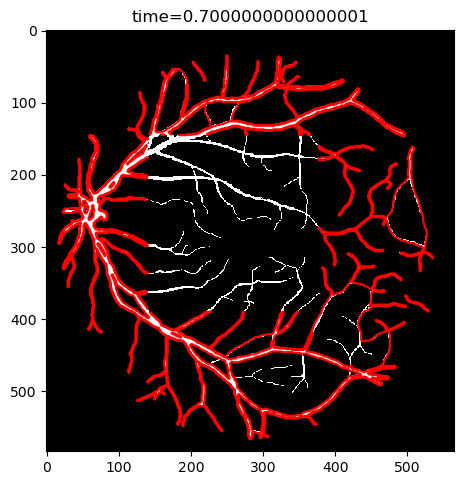

0.04961054604760067


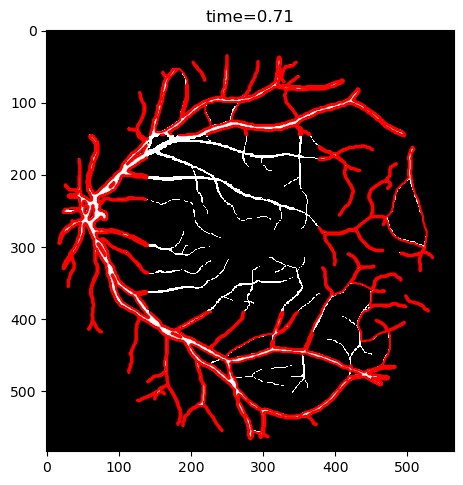

0.04961054604760067


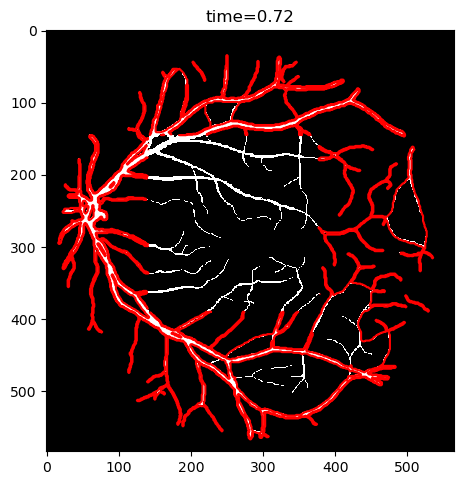

0.0496103781852387


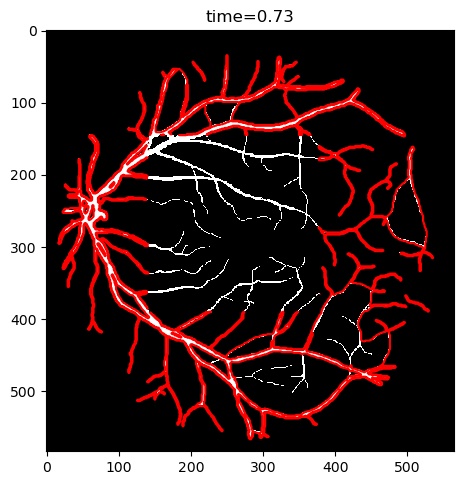

0.04961021032401269


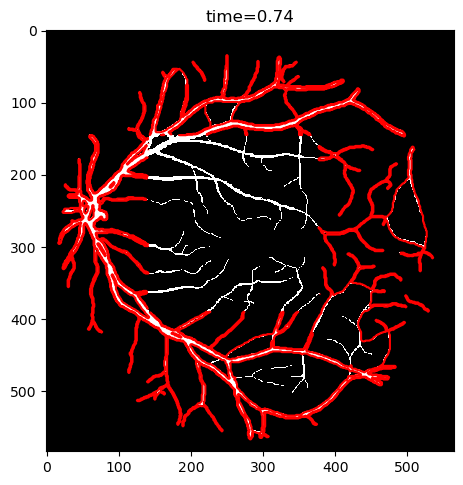

0.049610042463922574


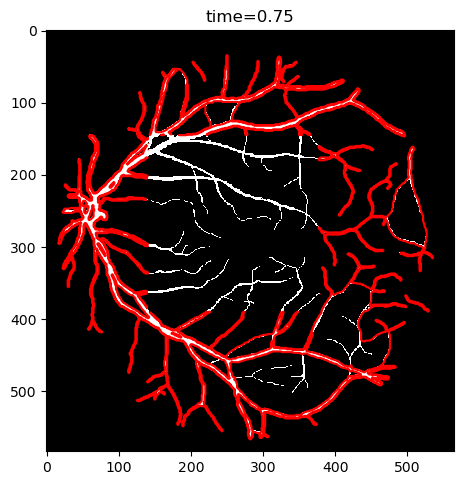

0.049610042463922574


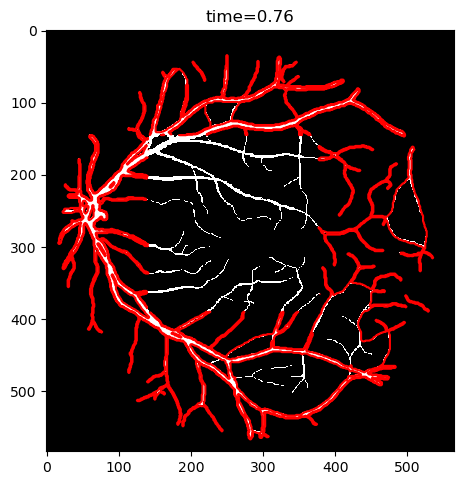

0.04961325817300861


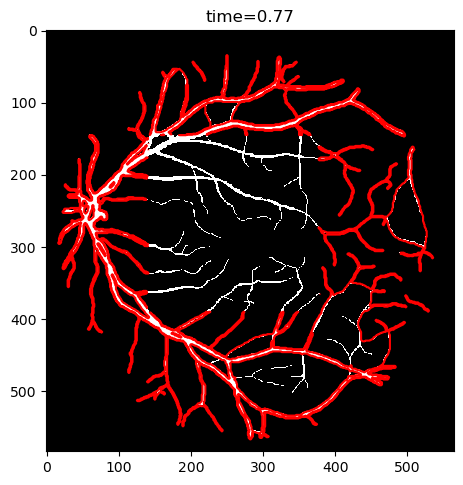

0.04961309030374189


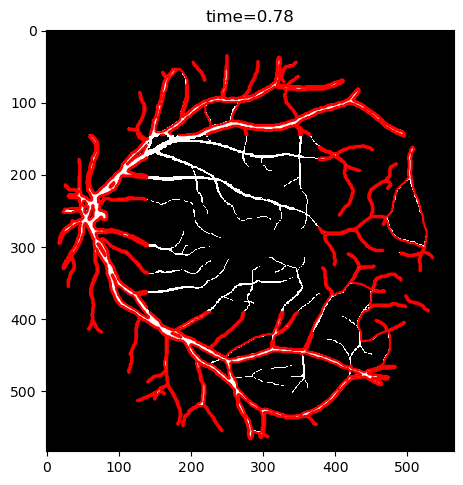

0.04961309030374189


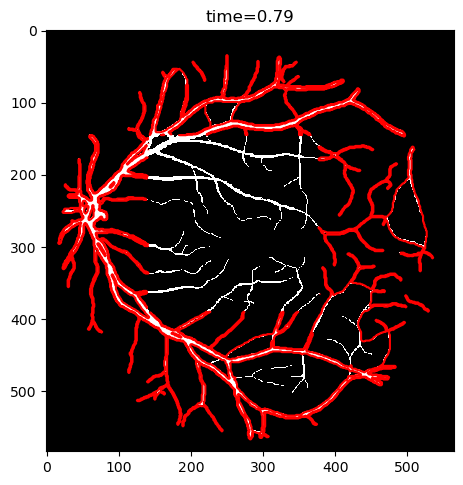

0.04961309030374189


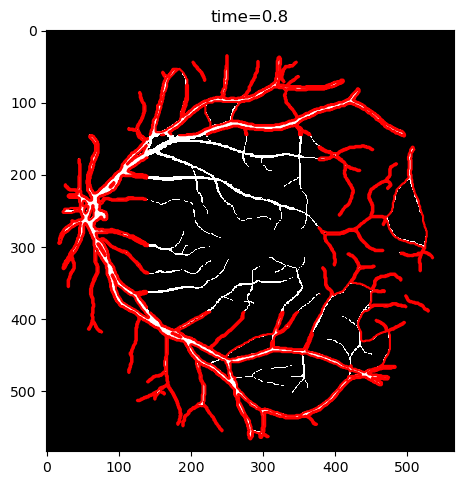

0.04961309030374189


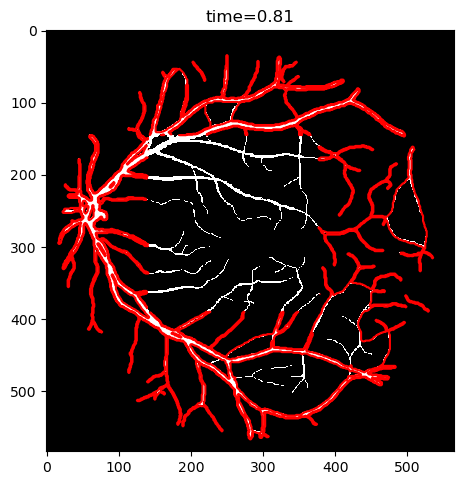

0.049616138102311295


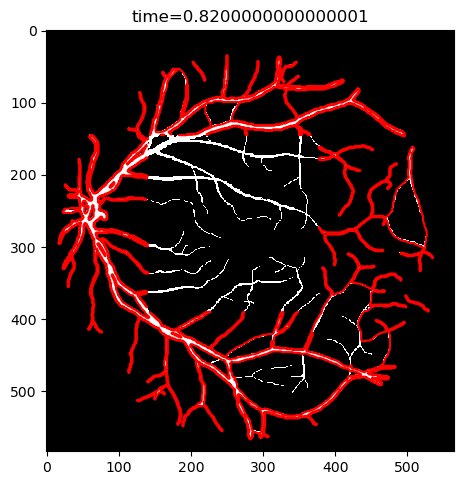

KeyboardInterrupt: 

In [222]:

phi = np.zeros(img.shape)
dt = 0.001
nt = 20000
timesch = TimeScheme(dt)
spatialsch = SpatialScheme
solver = levelset(phi, dt, nt, timesch.EulerForward, spatialsch.Upwind)
solver.evolve()